In [ ]:
import nltk
from nltk.corpus import brown
import numpy as np
from numba import njit
nltk.download('brown',quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# Hidden Markov Model
|||
|---|---|
| $Q=q_1q_2\dots q_N$ | a set of N states|
| $A=a_{11}\dots a_{ij}\dots a_{NN}$ | a transition probability matrix $A$, each $a_{ij}$ representing the probability of moving from state $i$ to state $j$, s.t. $\sum_{j=1}^N a_{ij} = 1 \ \forall i$|
| $B=b_i(o_t)$ | a sequence of observation likelihoods, also called emission probabilities, each expressing the probability of an observation $o_t$ (drawn from a vocabulary $V = v_1, v_2, \dots, v_V$) being generated from a state $q_i$|
|$\pi = \pi_1, \pi_2, \dots, \pi_N$| an initial probability distribution over states. $\pi_i$ is the probability that the Markov chain will start in state $i$. Some states $j$ may have $\pi_j = 0$, meaning that they cannot be initial states. Also, $\sum_{i=1}^N \pi_i = 1$|



# To calculate prior probabilities

<!-- Probability of next tag being $tag_i$ given the current tag is $tag_j$
$$
    \text{Transition probability matrix} \rightarrow P(\text{tag}_i\ | \text{tag}_j) \\
$$

Probability of observing word $o_i$ given the hidden state i.e the tag is $tag_j$ -->

In [ ]:
words = list(set(brown.words()))
pos_tags = ['VERB','NOUN','PRON','ADJ','ADV','ADP','CONJ','DET','NUM','PRT','.','X']
# pos_tags = list(set(pair[1] for pair in brown.tagged_words(tagset='universal')))
tagged_sents = list(brown.tagged_sents(tagset='universal'))

In [ ]:
def to_numpy(XY:list[list[tuple[str,str]]], X_name:list, Y_name:list, to_sort=False):
    X_id_map = {v: i for i, v in enumerate(X_name)}
    Y_id_map = {v: i for i, v in enumerate(Y_name)}
    if to_sort: XY = sorted(XY,key=len)
        
    n = len(XY)
    m = max(len(s) for s in XY)
    ST = np.zeros((n, m, 2), dtype=np.int32)-1

    for i, s in enumerate(XY):
        for j, w in enumerate(s):
            ST[i, j] = np.array([X_id_map[w[0]], Y_id_map[w[1]]])

    return ST

ST = to_numpy(tagged_sents, words, pos_tags)

In [ ]:
@njit
def get_prob(stB:np.ndarray, no_words:int, no_tags:int, eps:float=0.00001):
    A = np.zeros((no_tags,no_tags), dtype=np.float64)
    B = np.zeros((no_tags,no_words), dtype=np.float64)
    Pi = np.zeros(no_tags, dtype=np.float64)

    m, n, _ = stB.shape
    
    for i in range(m):
        if stB[i,0,0] == -1 : break
        Pi[stB[i,0,1]] += 1
        for j in range(n-1):
            wnth = stB[i,j,0]
            nth, nnth = stB[i,j:j+2,1]
            B[nth, wnth] += 1
            if nnth == -1 : break
            A[nth,nnth] += 1
        if nnth != -1 : B[stB[i,n-1,1], stB[i,n-1,0]] += 1
    A /= np.sum(A,axis=1).reshape(-1,1) + eps
    B /= np.sum(B,axis=1).reshape(-1,1) + eps
    Pi /= np.sum(Pi) + eps
    return A, B, Pi

A, B, Pi = get_prob(ST, len(words), len(pos_tags))

# Viterbi parameters
|||
|---|---|
 |$v_{t-1}(i)$ | the previous Viterbi path probability from the previous time step|
 |$a_{ij}$ | the transition probability from previous state $q_i$ to current state $q_j$|
 |$b_j(o_t)$| the state observation likelihood of the observation symbol ot given the current state $j$|

In [ ]:
from viterbi import viterbi_log

# ST = to_numpy(tagged_sents, words, pos_tags)
# A, B, Pi = get_prob(ST, len(words), len(pos_tags))

r = 1028          # sample number to test
test_sent = []
test_tags = []
for word, tag in tagged_sents[r]:
    test_sent.append(word)
    test_tags.append(tag)
# producing observation states (words) in terms of its word index
O = [words.index(word) for word in test_sent] 

optim_state_seq, log_prob_trellis, backtrack_matrix = viterbi_log(O,A,Pi,B)

optim_state_seq = [pos_tags[t] for t in optim_state_seq]

# The following was to check if it was working or not. These parts need to be better done.
print('Observation sequence:   O  = ', test_sent)
print('Correct state sequence: S* = ', test_tags)
print('Optimal state sequence: S  = ', optim_state_seq)
print("Do they match ? : ", test_tags==optim_state_seq)

import pandas as pd
test_result_df = pd.DataFrame(index=test_sent,columns=['Correct','Guessed'],data=zip(test_tags,optim_state_seq)).T
test_result_df.iloc[:,(test_result_df.nunique()!=1).values]

Observation sequence:   O  =  ['Catcher', 'Frank', "House's", 'throw', 'in', 'an', 'effort', 'to', 'nab', 'Throneberry', 'was', 'wide', 'and', 'in', 'the', 'dirt', '.']
Correct state sequence: S* =  ['NOUN', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'DET', 'NOUN', 'PRT', 'VERB', 'NOUN', 'VERB', 'ADV', 'CONJ', 'ADP', 'DET', 'NOUN', '.']
Optimal state sequence: S  =  ['NOUN', 'NOUN', 'NOUN', 'VERB', 'ADP', 'DET', 'NOUN', 'PRT', 'VERB', 'NOUN', 'VERB', 'ADJ', 'CONJ', 'ADP', 'DET', 'NOUN', '.']
Do they match ? :  False


,throw,wide
Correct,NOUN,ADV
Guessed,VERB,ADJ


# Kfold 

In [ ]:
@njit(parallel=True)
def viterbi_parll(Xx,A,Pi,B):
    out = np.zeros(Xx.shape, dtype=np.int16)-1
    for i in range(Xx.shape[0]):
        O = Xx[i]
        O = O[O>-1]
        out[i,:O.shape[0]], _, _ = viterbi_log(O, A, Pi, B)
    return out

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
# from random import sample, seed
# seed(637)

# Define number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=89)

ST = to_numpy(tagged_sents, words, pos_tags)

accuracies = []
conf_matrices = []
for train_index, test_index in kf.split(ST):
    # Split data into training and testing sets
    train_ST = ST[train_index]
    test_ST =  ST[test_index]
    test_ST_o, test_ST_q = np.moveaxis(test_ST,-1,0)

    A, B, Pi = get_prob(train_ST, len(words), len(pos_tags))
    
    # Testing
    pred = viterbi_parll(test_ST_o, A, Pi, B)
    
    assert ((pred == -1) == (test_ST_q == -1)).all()
    conf_matx = confusion_matrix(pred[pred!=-1].ravel(),test_ST_q[test_ST_q!=-1].ravel())
    
    # Per label accuracy which i think turns out same as precision
    prec_s = conf_matx.sum(axis=0)
    prec_s[prec_s==0] = 1 # handling division by zero
    precis = conf_matx.diagonal() / prec_s
    # calc recall also, just in case
    # rec_s = conf_matx.sum(axis=1)
    # rec_s[rec_s==0] = 1 # handling division by zero
    # recal = conf_matx.diagonal() / rec_s
    
    accuracies.append(precis)
    conf_matrices.append(conf_matx)

per_tag_acc = np.array(accuracies).mean(axis=0)
print('Per tag accuracies :\n',per_tag_acc)
print('Confusion matrices from every fold :\n',*conf_matrices,sep='\n')

Per tag accuracies :
 [0.95071283 0.94981182 0.9850441  0.91142681 0.89520908 0.96835217
 0.99499212 0.98674635 0.91368055 0.90717005 0.49413643 0.999844  ]
Confusion matrices from every fold :

[[34765   622     0   120    49    20     0     0     5     8     4     0]
 [ 1260 52339     9   520    96     8     1     0   135    40    73     0]
 [   10   139  9715     8    16    69     0   200    10     4     0     0]
 [  124   690     0 15414   422    17     0     0    20     4     2     0]
 [   25    34     0   444 10187   395     9    18     0    35     0     0]
 [  216   211    77    29   347 27925     1   118     8   464     9     0]
 [    0     0     0     0    19    27  7640     4     0     0     0     0]
 [   87   407    59   266    59    29    12 27041    75     0    21     0]
 [    0    78     0     2     0     0     0     0  2802     0     1     0]
 [    5    21     0    37   157   308     0     0     0  5323     0     0]
 [    0    22     0     2     0     0     0     0     1

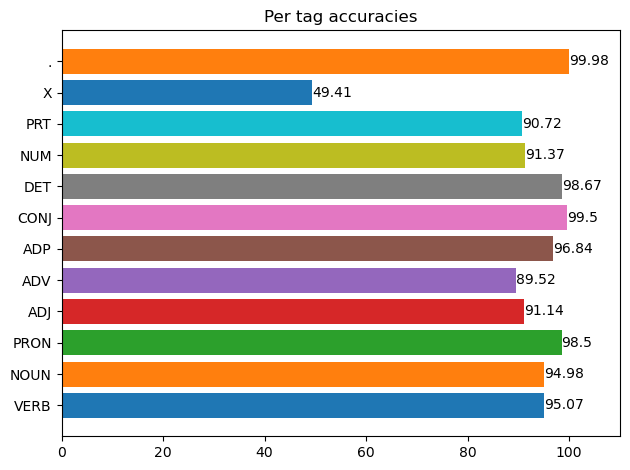

In [ ]:
import matplotlib.pyplot as plt
per_tag_acc = np.array(accuracies).mean(axis=0)
fig, ax = plt.subplots(layout='tight')
bars = ax.barh(pos_tags, np.round(per_tag_acc,4)*100,color=['C'+str(k) for k in range(len(pos_tags))])
ax.bar_label(bars)
ax.set_xlim(0,110)
ax.set_title('Per tag accuracies')
plt.show()

# User testing

In [ ]:
from nltk.tokenize import word_tokenize
s = input("Enter sentence to test : \n")
test_sent = word_tokenize(s)
O = [words.index(tok) if tok in words else len(words) for tok in test_sent]

optim_state_seq, log_prob_trellis, backtrack_matrix = viterbi_log(O,A,Pi,B)

optim_state_seq = [pos_tags[t] for t in optim_state_seq]

s_t = list(zip(test_sent,optim_state_seq))
print('Observation sequence and Optimal state sequence:\n', s_t)

from nltk.tag import pos_tag
rec_t = pos_tag(test_sent, tagset='universal')
rec_t = [p[1] for p in rec_t]
vi = pd.DataFrame(zip(test_sent, optim_state_seq, rec_t, ['']*len(rec_t)), columns=['Tokens','Predicted POS tag','NLTK lib tagged','Mismatch'])
vi['Mismatch'] = np.where(vi['Predicted POS tag']!=vi['NLTK lib tagged'], '●', '')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(vi)

Observation sequence and Optimal state sequence:
 [('The', 'DET'), ('rulers', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Vijayanagara', '.'), ('Empire', 'NOUN'), ('maintained', 'VERB'), ('the', 'DET'), ('administrative', 'ADJ'), ('methods', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('their', 'DET'), ('predecessors', 'NOUN'), (',', '.'), ('the', 'DET'), ('Hoysala', '.'), (',', '.'), ('Kakatiya', '.'), ('and', 'CONJ'), ('Pandya', '.'), ('kingdoms', 'NOUN'), ('.', '.'), ('[', '.'), ('75', 'NUM'), (']', '.'), ('The', 'DET'), ('emperor', 'NOUN'), (',', '.'), ('ministry', 'NOUN'), (',', '.'), ('territory', 'NOUN'), (',', '.'), ('fort', 'NOUN'), (',', '.'), ('treasury', 'NOUN'), (',', '.'), ('military', 'ADJ'), (',', '.'), ('and', 'CONJ'), ('ally', 'NOUN'), ('formed', 'VERB'), ('the', 'DET'), ('seven', 'NUM'), ('critical', 'ADJ'), ('elements', 'NOUN'), ('that', 'PRON'), ('influenced', 'VERB'), ('every', 'DET'), ('aspect', 'NOUN'), ('of', 'ADP'), ('governance', '.'), ('.', '.')]


,Tokens,Predicted POS tag,NLTK lib tagged,Mismatch
0,The,DET,DET,
1,rulers,NOUN,NOUN,
2,of,ADP,ADP,
3,the,DET,DET,
4,Vijayanagara,.,NOUN,●
5,Empire,NOUN,NOUN,
6,maintained,VERB,VERB,
7,the,DET,DET,
8,administrative,ADJ,ADJ,
9,methods,NOUN,NOUN,
